In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagnetizationFourierKernel2d
from magrec.misc.plot import plot_n_components
from magrec.prop.Propagator import FourierPadder, MagnetizationPropagator2d
from magrec.misc.load import load_matlab_data

from magrec import __datapath__

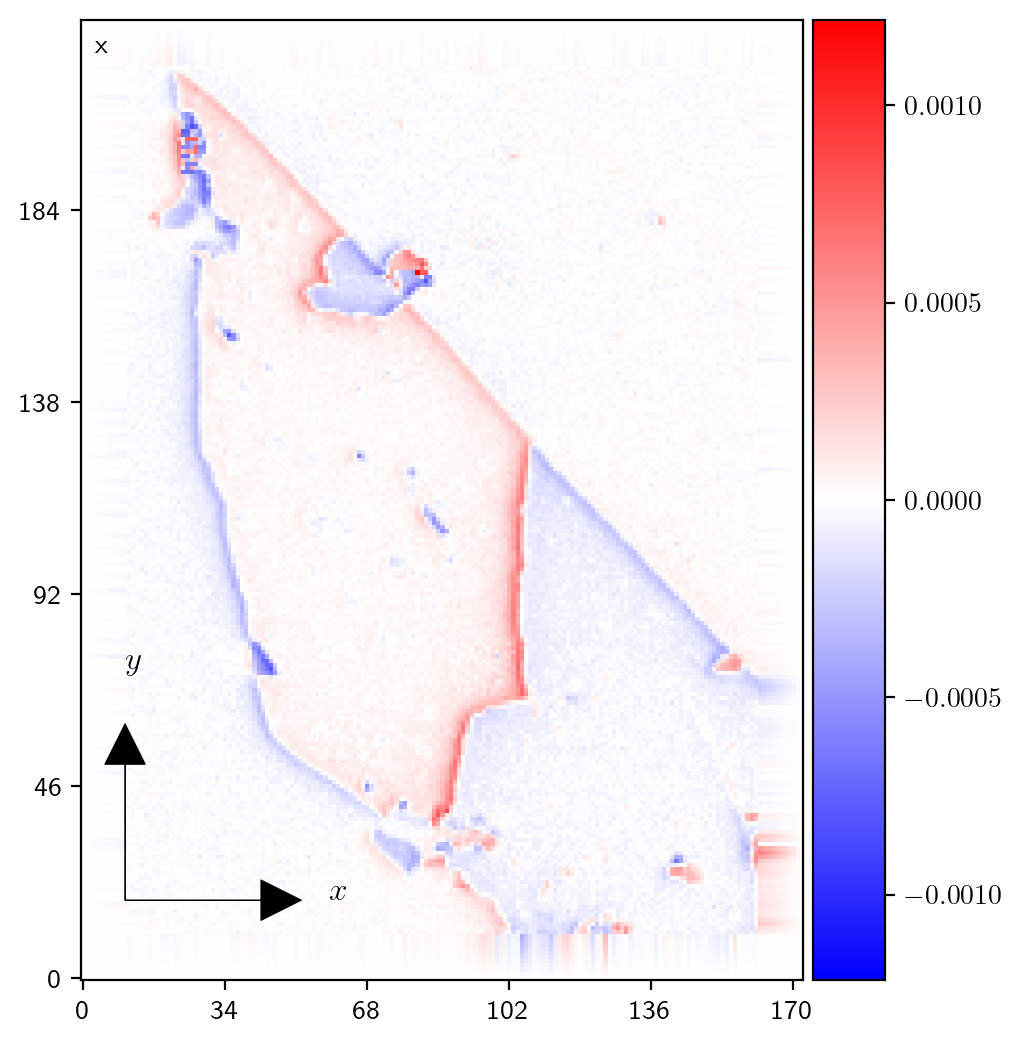

In [422]:
f = open(__datapath__ / "Magnetisation out of plane" / "CrI3_Exp_B_20180622_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
B_NV = torch.from_numpy(np.array(BNV))


sensor_theta = data["ExperimentMagneticField"]['BNV']['Theta'] +3
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] -90

Bpad = FourierPadder.pad_2d(B_NV, (10,10), 'linear_ramp')
plot_n_components(Bpad, symmetric=True, cmap="bwr")

In [430]:
# data from inspecting the matlab file  
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6


ft = FourierTransform2d(Bpad.shape, dx=dx, dy=dy)
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=sensor_theta, phi=sensor_phi)

g:\Dropbox\Dropbox\Programming\Python\magrec\magrec\notebooks\Test Magnetisation Reconstruction\../../..\magrec\misc\plot.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  datum = np.float64(data[i // n_components][i % n_components]).T  # convert to float64 to avoid an issue with matplotlib and casting


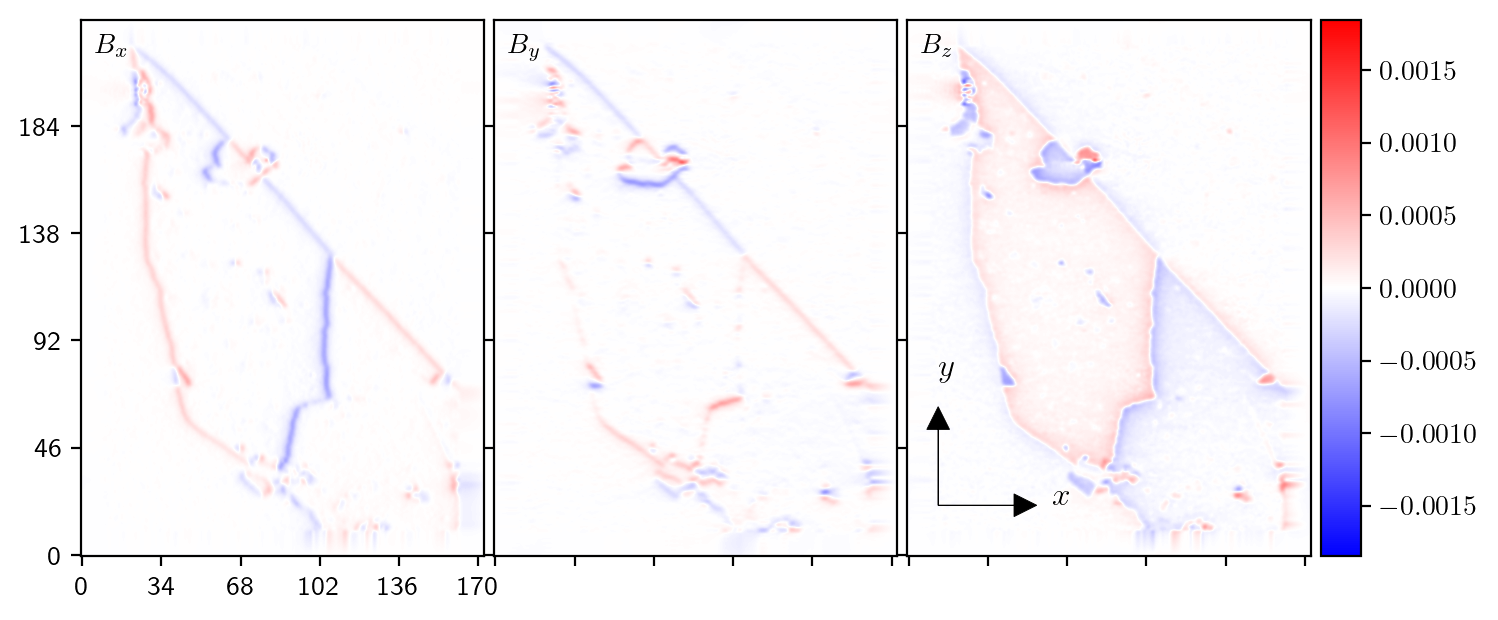

In [431]:
b_NV = ft.forward(Bpad, dim=(-2, -1))
b = torch.einsum("jkl,kl-> jkl", kernel, b_NV)
Bharmonic = ft.backward(b, dim=(-2, -1))
plot_n_components(Bharmonic, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

In [432]:
height = data['ExperimentMagneticField']['BNV']['Height'] *1e6 # in μm
layer_thickness = 0 # put 1 for now to get result per μm
inversion_kernel = MagnetizationFourierKernel2d.define_kernel_matrix(ft.kx_vector, ft.ky_vector, height=height, layer_thickness=layer_thickness)

In [433]:
bxyz = b.type(dtype=torch.complex64)
m = torch.einsum('vcjk,cjk->cjk', inversion_kernel, bxyz)

M = ft.backward(m, dim=(-2, -1))

mz = inversion_kernel[2,2,::]*bxyz[2,::] 
Mz = ft.backward(mz, dim=(-2, -1))

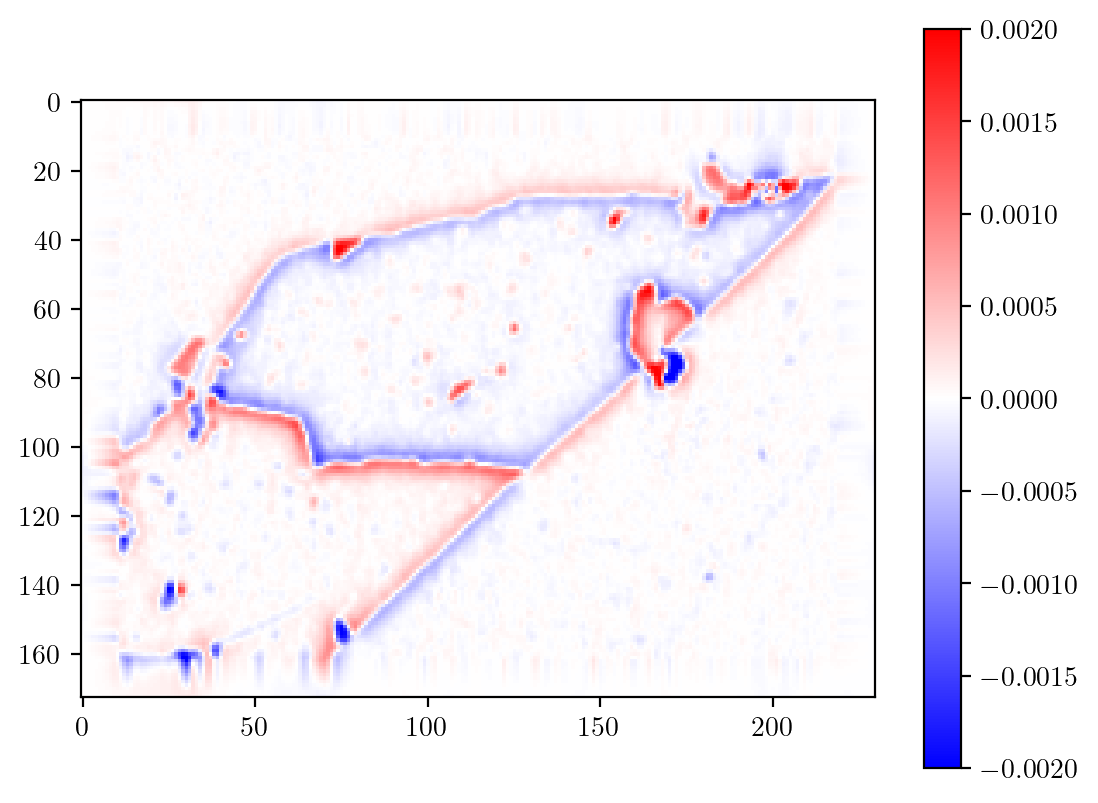

In [435]:
plt.figure()
plt.imshow(Mz , cmap='bwr', vmin=-0.002, vmax = 0.002)
plt.colorbar()

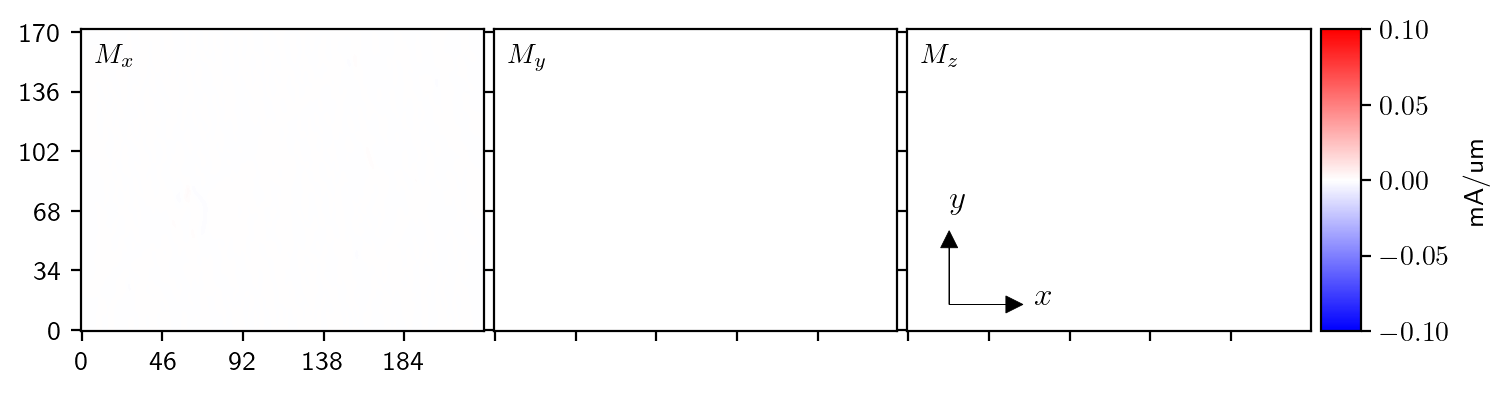

In [410]:
plot_n_components(M, symmetric=True, labels=[r"$M_x$", r"$M_y$", r"$M_z$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "interpolation": "bicubic",
    })

## Background substraction

Above we see that $J_x$, $J_y$ reconstruction has artifacts in a form of sort of background offsets. $J_y$ artifact is in the form of a background constant spatial DC offset, whereas $J_x$ is a more complicated one: Maybe it can be corrected by a plane $J_{x, \text{offset}} = ax + by$? 

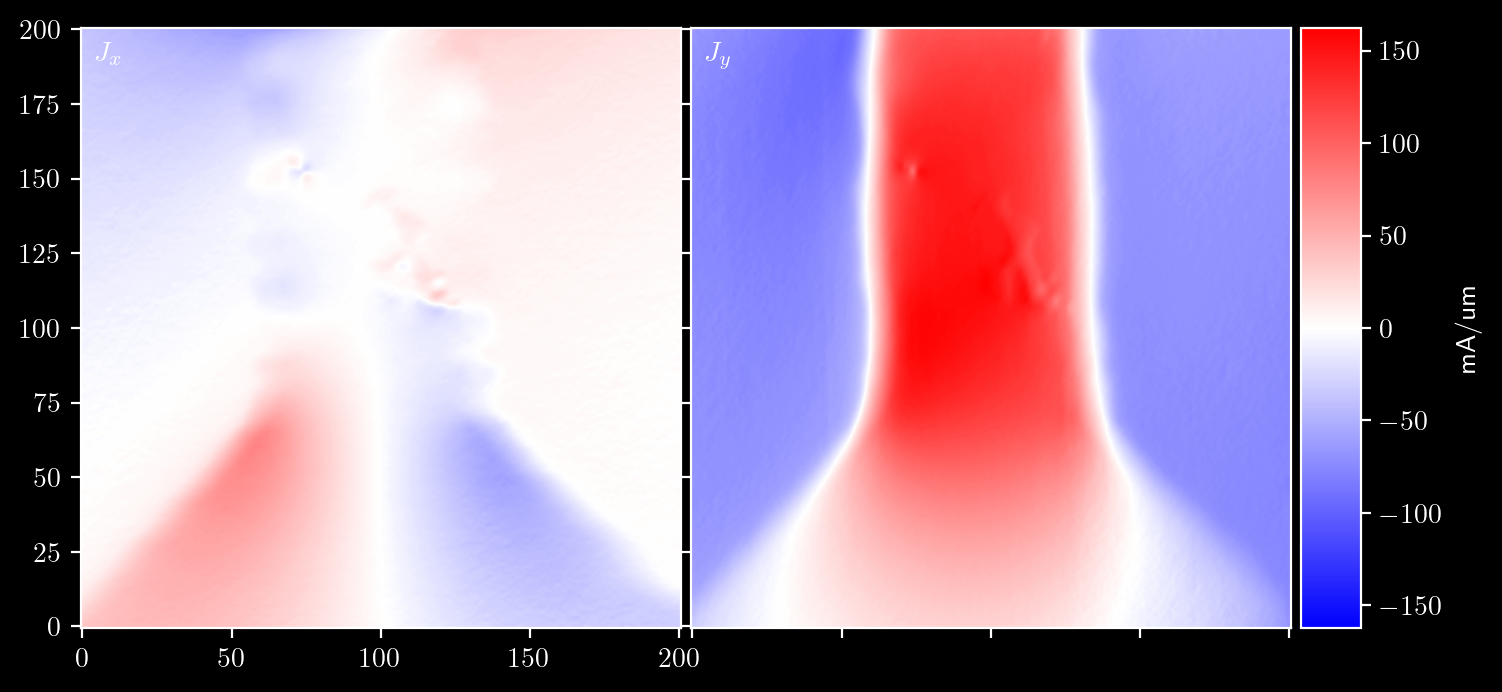

In [136]:
# there is a wrong way to correct the current density by subtracting the mean of each component across the image
# plotting the result, we see that the effect is not becaucase of the mean shift
def wrong_correct_background(J: torch.tensor):
    J = J - J.mean(dim=(-2, -1), keepdim=True)
    return J

plot_n_components(wrong_correct_background(JxJy[:,100:301,100:301]), symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", units="mA/um",
imshow_kwargs={
    "interpolation": "bicubic",
    })


In [137]:
def correct_background(J: torch.tensor):
    # that's the region where J_y component should be zero but it is not
    Jy_zero_region = J[1, 150:200, 150:200]
    Jy_offset = Jy_zero_region.mean()

    Jx_zero_region_1 = J[0, 0:50, 150:200]
    Jx_offset_1 = Jx_zero_region_1.mean()

    Jx_zero_region_2 = J[0, 150:200, 150:200]
    Jx_offset_2 = Jx_zero_region_2.mean()
    
    # for J_x component, we want to correct for a linear variation so that the values for the Jx_offset 
    # vary from Jx_offset_1 to Jx_offset_2 across the width of the image
    Jx_offset = torch.linspace(Jx_offset_1, Jx_offset_2, J.shape[-2])
    J[0, :, :] = J[0, :, :] - Jx_offset[:, None]
    J[1, :, :] = J[1, :, :] - Jy_offset
    plot_n_components(J, symmetric=True, cmap="bwr", show=True)
    return J

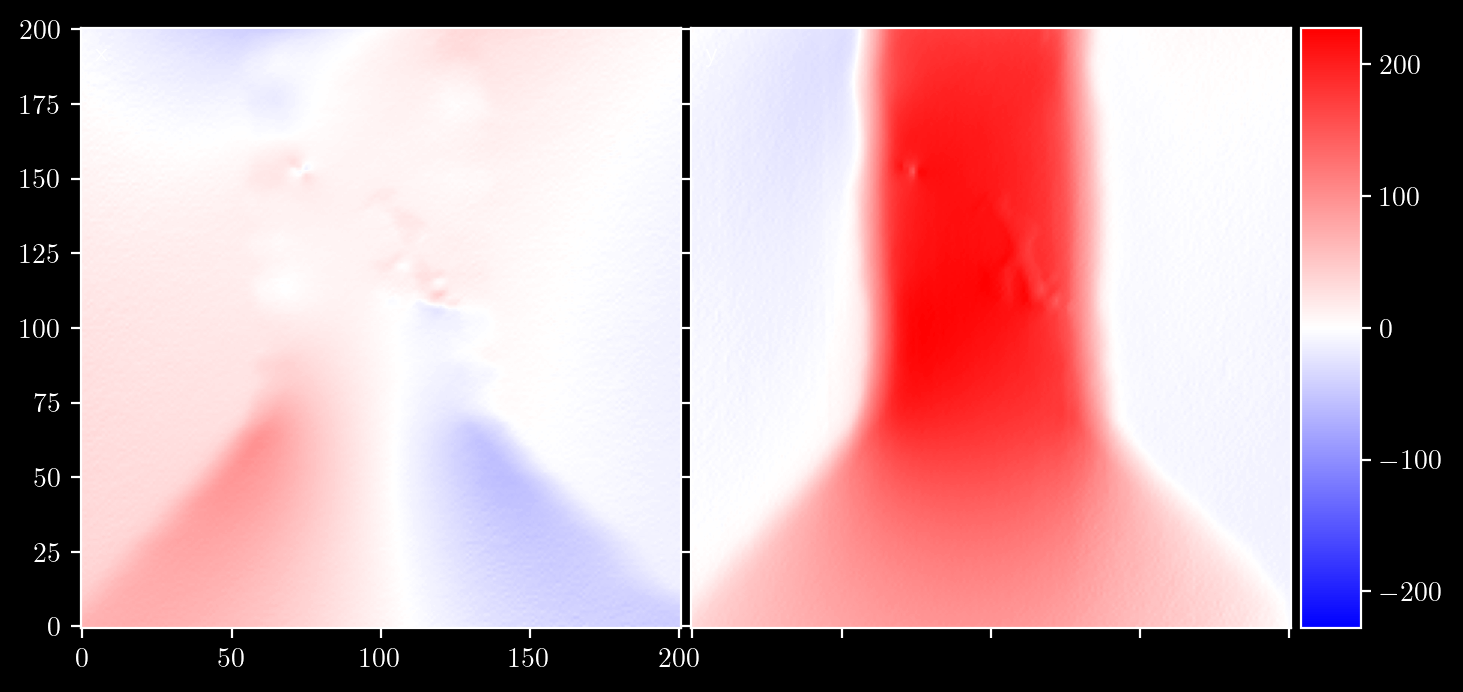

In [138]:
J_corrected = correct_background(JxJy[:,100:301,100:301])

Check that the reconstructed current produces the expected magnetic field. For that, take `JxJy` and input it into a reasonable propagator algorithm to obtain $B$ field.



In [139]:
from magrec.prop.Propagator import HeightContinuationPadder, ZeroPadder, CurrentPropagator2d, AxisProjectionPropagator

In [140]:
shape = J_corrected.shape
pad1 = HeightContinuationPadder(shape=shape)
pad2 = ZeroPadder(shape=pad1.expanded_shape)
propagator = CurrentPropagator2d(source_shape=pad2.expanded_shape,
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)
proj = AxisProjectionPropagator(theta=theta, phi=phi)

def compute_B(J: torch.tensor):
    J = pad1.pad(J)
    fig = plot_n_components(J, symmetric=True, labels=[r"$J_x$", r"$J_y$"], cmap="bwr", show=True)
    fig.suptitle("Padded J", y=0.86)
    J = pad2.pad(J)
    B = propagator(J)
    B = pad2.unpad(B)
    B = pad1.unpad(B)
    B_NV = proj.project(B)
    B = torch.concat((B, B_NV[None, ...]), dim=0)
    return B


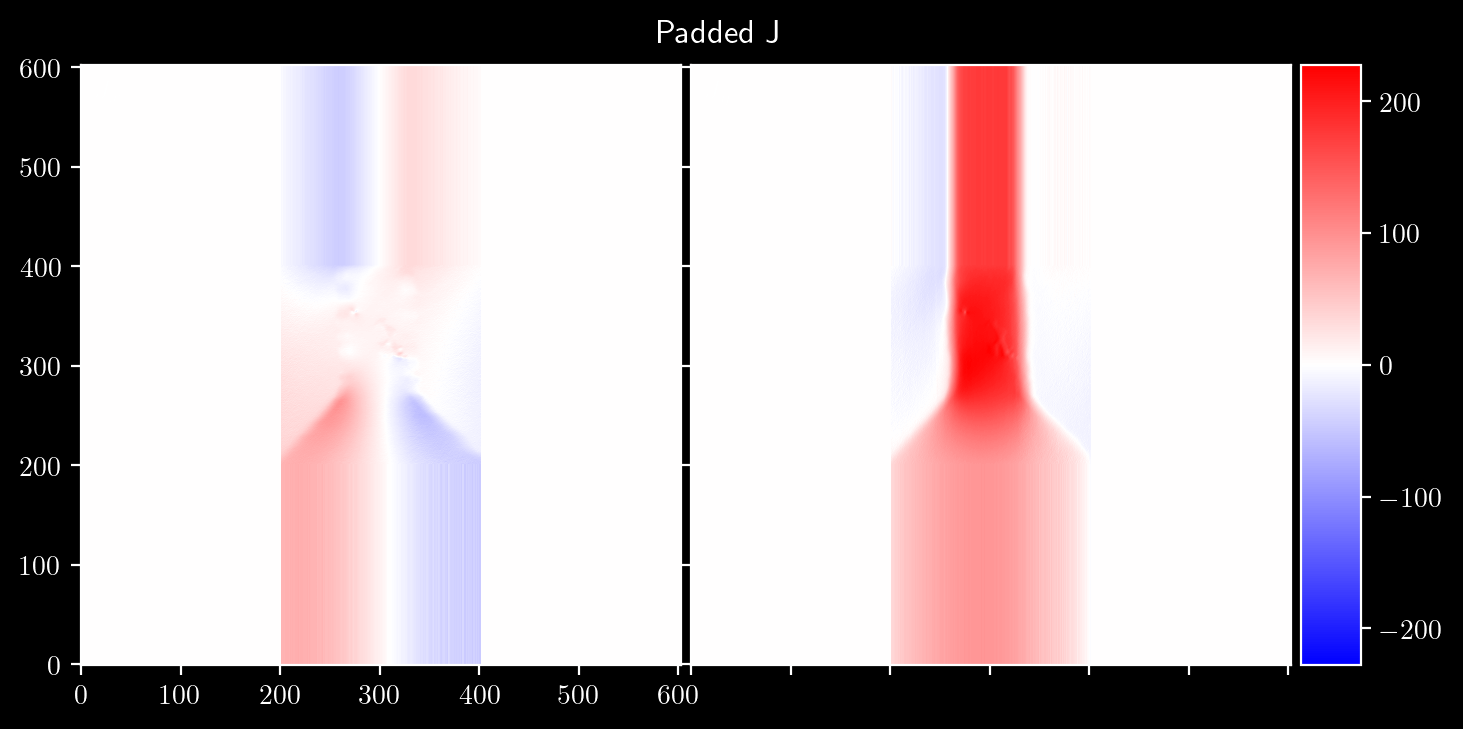

In [141]:
reconstructedB = compute_B(J_corrected)

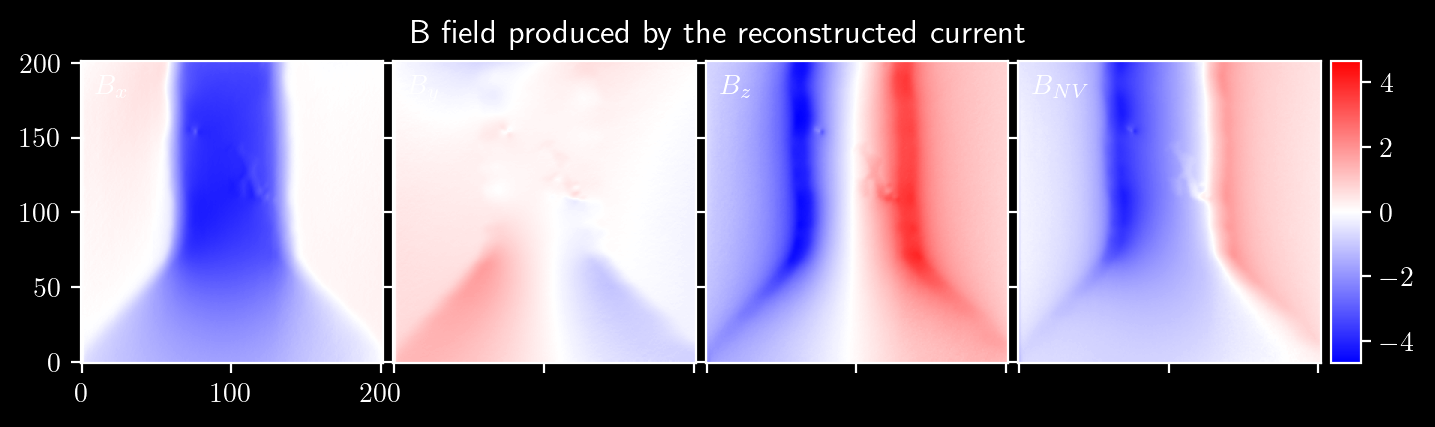

In [142]:
fig = plot_n_components(reconstructedB, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")
fig.suptitle("B field produced by the reconstructed current", y=0.7)
fig

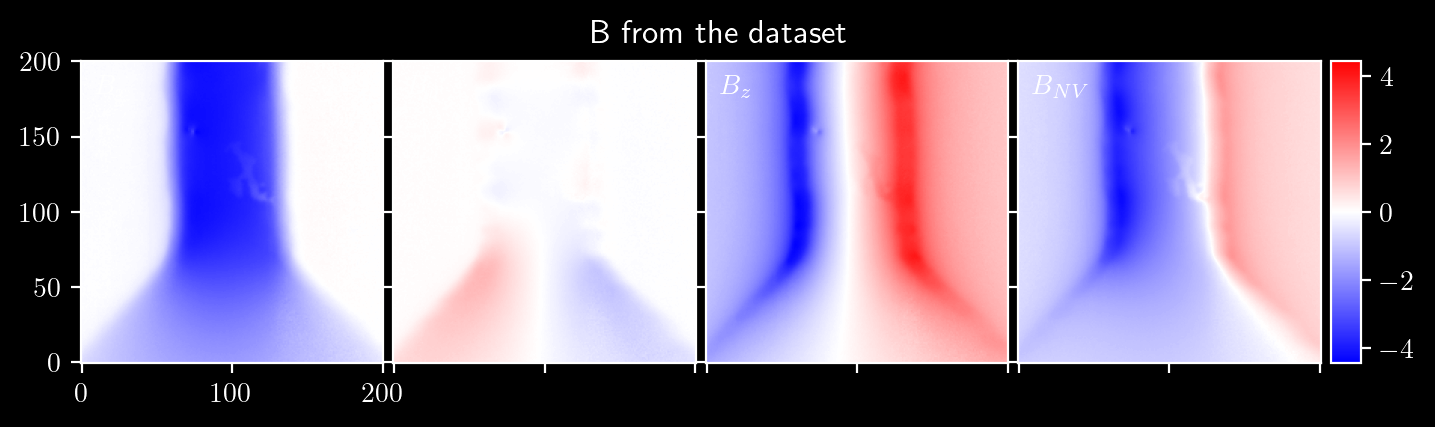

In [143]:
fig = plot_n_components(B, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr")
fig.suptitle("B from the dataset", y=0.7)
fig